In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torchvision
import PIL
import os
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import tqdm
import torch.utils.data as data
import glob
path = '/content/drive/My Drive/Inria_data/Video/'

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=(160, 384), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.3651, 0.2656, 0.2544], [0.1847, 0.1425, 0.1418])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(160, 384)),
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.3651, 0.2656, 0.2544], [0.1847, 0.1425, 0.1418])
    ]),
}

In [0]:
class Inria(data.Dataset):
    def __init__(self, folder_path, transform=None):
        super(Inria, self).__init__()
        self.left_files = glob.glob(os.path.join(folder_path,'left','*.jpg'))
        self.right_files = glob.glob(os.path.join(folder_path,'left','*.jpg'))

        self.transform = transform
        # self.mask_files = []
        # for img_path in img_files:
        #      self.mask_files.append(os.path.join(folder_path,'mask',os.path.basename(img_path)) 

    def __getitem__(self, index):

            left_img_path = self.left_files[index]
            right_img_path = self.right_files[index]

            left = Image.open(left_img_path)
            right = Image.open(right_img_path)

            if self.transform:
              left = self.transform(left)
              right = self.transform(right)

            # left = torchvision.transforms.ToTensor()(Image.open(left_img_path))
            # right = torchvision.transforms.ToTensor()(Image.open(right_img_path))

            # img = torchvision.transforms.ToTensor()(img)Œ

            return left, right

    def __len__(self):
        return len(self.left_files)

In [0]:
# Custom Dataloader
class ImageDataset(Dataset):
    def __init__(self, main_dir):
        file_list = os.listdir(main_dir)
        self.file_list = file_list
        self.main_dir = main_dir
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.main_dir + '/' + self.file_list[index])
        img = torchvision.transforms.ToTensor()(img)
        return img

In [0]:
# train_dataset = ImageDataset(path, transform=data_transforms['train'])
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
train_dataset = Inria(path, data_transforms['train'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=8)

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained Mask RCNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

# Test on a sample image
# image = PIL.Image.open(path + '00004390.jpg')
# image_tensor = torchvision.transforms.functional.to_tensor(image)
# output = model([image_tensor])

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [8]:
len(train_dataloader)

2727

In [0]:
# Generate Masks for each image
outputs = []
for (img, _) in tqdm.tqdm(train_dataloader):
    img = img.to(device)
    out = model(img)

    # Ignore background class
    indices = out[0]['labels'] != 0

    # Threshold at 0.7 confidence (Can try a different confidence)
    masks = (out[0]['masks'] > 0.7).float() * 1

    # Shape [N,1,H,W] -> [1,H,W] where N is Number of masks
    summed_mask = torch.clamp(torch.sum(masks[indices], dim=0), min=0, max=1)
    outputs.append(summed_mask.detach().cpu())
    torch.cuda.empty_cache()
    del img

print(len(outputs))

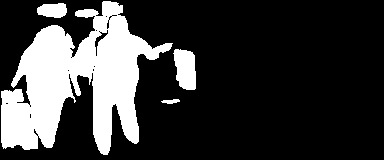

In [72]:
# Visualize a mask
Image.fromarray(outputs[0][0].mul(255).byte().cpu().numpy())

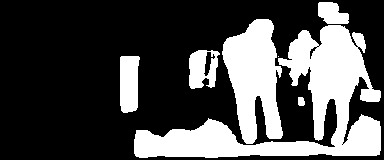

In [73]:
# Visualize a mask
Image.fromarray(outputs[1][0].mul(255).byte().cpu().numpy())

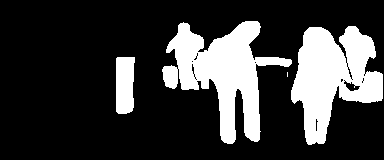

In [74]:
# Visualize a mask
Image.fromarray(outputs[5][0].mul(255).byte().cpu().numpy())

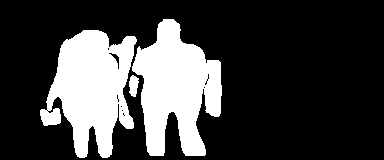

In [75]:
# Visualize a mask
Image.fromarray(outputs[200][0].mul(255).byte().cpu().numpy())

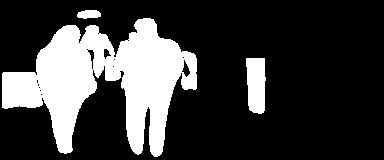

In [78]:
# Visualize a mask
Image.fromarray(outputs[50][0].mul(255).byte().cpu().numpy())